In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder

import os, cv2
from tqdm import tqdm

In [2]:
def label_assignment(img,label):
    return label

def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(imgsize,imgsize))

        X.append(np.array(img))
        Z.append(str(label))
        
chihuahua_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02085620-Chihuahua"
japanese_spaniel_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02085782-Japanese_spaniel"
maltese_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02085936-Maltese_dog"
pekinese_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02086079-Pekinese"
shitzu_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02086240-Shih-Tzu"
blenheim_spaniel_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02086646-Blenheim_spaniel"
papillon_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02086910-papillon"
toy_terrier_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02087046-toy_terrier"
afghan_hound_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02088094-Afghan_hound"
basset_dir = "C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Stanford Dogs\\images\\Images\\n02088238-basset"


X = []
Z = []
imgsize = 8

In [3]:
training_data('chihuahua',chihuahua_dir)
training_data('japanese_spaniel',japanese_spaniel_dir)
training_data('maltese',maltese_dir)
training_data('pekinese',pekinese_dir)
training_data('shitzu',shitzu_dir)
training_data('blenheim_spaniel',blenheim_spaniel_dir)
training_data('papillon',papillon_dir)
training_data('toy_terrier',toy_terrier_dir)
training_data('afghan_hound',afghan_hound_dir)
training_data('basset',basset_dir)

100%|███████████████████████████████████████| 175/175 [00:00<00:00, 486.97it/s]


In [4]:
# Load Data
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

# Y = to_categorical(Y,10)
X = np.array(X)
X = X.reshape(X.shape[0], -1)
X=X/255

[BernoulliRBM] Iteration 1, pseudo-likelihood = -39.66, time = 0.30s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -38.74, time = 0.44s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -38.16, time = 0.45s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -37.84, time = 0.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -37.64, time = 0.42s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -37.82, time = 0.45s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -37.57, time = 0.45s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -37.48, time = 0.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -37.55, time = 0.47s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -37.58, time = 0.47s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -37.39, time = 0.45s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -37.53, time = 0.45s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -37.46, time = 0.45s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -37.58, time = 0.47s
[BernoulliRBM] Iteration 15, 

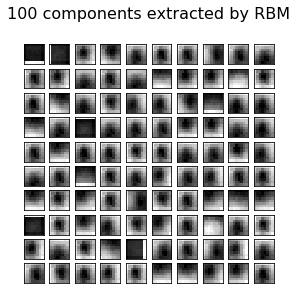

In [5]:
# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, Y = nudge_dataset(X, Y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# # #############################################################################
# # Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    if i == 100:
        break
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()